# Time Series - Classification

**Classification task** on the time series dataset(s) and evaluation of the result. 

    1 shapelet-based classifiers
    2 structural-based classifiers

In [1]:
#### Importing Libraries
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

### Load Raw Data

There are three main signal types in the raw data: **total acceleration**, **body acceleration**, and **body gyroscope**. Each has 3 axises of data (x, y, z). This means that there are a total of nine variables for each time step.

Further, each series of data has been partitioned into overlapping windows of 2.56 seconds of data, or 128 time steps. These windows of data correspond to the windows of engineered features (rows) in the previous section.

This means that one row of data has (128 * 9), or 1,152 elements. This is a little less than double the size of the 561 element vectors in the previous section and it is likely that there is some redundant data.

Link on how to import the data: https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/

In [2]:
# load dataset
from numpy import dstack
from pandas import read_csv
 
# load a single file as a numpy array
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded
 
# load a dataset group, such as train or test
def load_dataset(group):
    filepath = group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(group + '/y_'+group+'.txt')
    return X, y
 
# load all train
X_train, y_train = load_dataset('train')
print(X_train.shape, y_train.shape)

# load all test
X_test, y_test = load_dataset('test')
print(X_test.shape, y_test.shape)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)


In [3]:
print(len(X_train), 'training series (with 50% overlap between each serie)')
print(len(X_train[0]), 'timesteps per series')
print(len(X_train[0][0]), 'attributes per timestep')

7352 training series (with 50% overlap between each serie)
128 timesteps per series
9 attributes per timestep


In [4]:
# tot_acc_x
X_train = X_train[:,:,0]
X_test  = X_test[:,:,0]  

In [5]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (7352, 128)
X_test shape: (2947, 128)


---

# Shapelet-based classifiers

https://tslearn.readthedocs.io/en/stable/gen_modules/tslearn.shapelets.html#module-tslearn.shapelets

In [6]:
import tensorflow as tf
from sklearn.metrics import classification_report

from pyts.preprocessing import RobustScaler
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.utils import ts_size

**Parameters**

- **n_ts**: int Number of time series in the dataset

- **ts_sz**: int Length of time series in the dataset

- **n_classes**: int Number of classes in the dataset

- **l**: float Fraction of the length of time series to be used for base shapelet length

- **r**: int Number of different shapelet lengths to use

**Returns:	**

- **dict**: Dictionary giving, for each shapelet length, the number of such shapelets to be generated


In [7]:
# Get statistics of the dataset
n_ts, ts_sz = X_train.shape[:2]
n_classes = len(np.unique(y_train))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=0.1, 
                                                       r=1)

In [8]:
# Define the model  Learning-based Approach
shp_clf = LearningShapelets(n_shapelets_per_size=shapelet_sizes,
                            optimizer=tf.optimizers.Adam(.01),
                            batch_size=16,
                            weight_regularizer=.01,
                            max_iter=200,
                            random_state=42,
                            verbose=0)

shp_clf.fit(X_train, y_train)

/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/tslearn/shapelets/shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "
/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LearningShapelets(batch_size=16, max_iter=200, n_shapelets_per_size={12: 6},
                  optimizer=<keras.optimizer_v2.adam.Adam object at 0x7fcd1d2d7df0>,
                  random_state=42, weight_regularizer=0.01)

In [9]:
# Make predictions and evaluate the classification result
y_pred = shp_clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.99      0.70       496
           2       0.95      0.36      0.52       471
           3       0.94      0.70      0.80       420
           4       1.00      0.07      0.13       491
           5       0.54      1.00      0.70       532
           6       1.00      1.00      1.00       537

    accuracy                           0.70      2947
   macro avg       0.83      0.68      0.64      2947
weighted avg       0.82      0.70      0.64      2947



In [10]:
df_shapelets = pd.DataFrame(shp_clf.shapelets_as_time_series_.squeeze()).transpose()
df_shapelets.columns = ['Shapelet 1', 'Shapelet 2', 'Shapelet 3', 'Shapelet 4', 'Shapelet 5', 'Shapelet 6', ]
df_shapelets.head()

,Shapelet 1,Shapelet 2,Shapelet 3,Shapelet 4,Shapelet 5,Shapelet 6
0,-1.584037,0.717180,5.235995,0.546223,-1.593874,0.717166
1,-0.249793,1.024498,6.166440,0.110917,-0.262834,1.024483
2,-0.077320,2.683959,5.435631,0.092009,-0.088809,2.683967
3,-0.476982,4.935375,3.990212,0.943042,-0.487537,4.935410
4,-1.091587,6.077539,2.545817,2.864810,-1.083086,6.077638


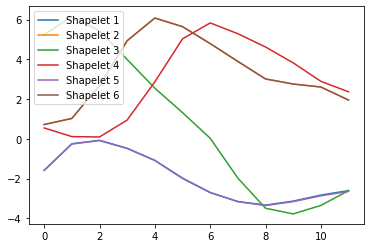

In [11]:
df_shapelets.plot()
plt.show()

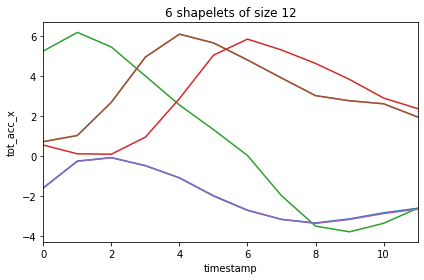

In [19]:
# Plot the different discovered shapelets
plt.figure()
for i, sz in enumerate(shapelet_sizes.keys()):
    plt.subplot(len(shapelet_sizes), 1, i + 1)
    plt.title("%d shapelets of size %d" % (shapelet_sizes[sz], sz))
    for shp in shp_clf.shapelets_:
        if ts_size(shp) == sz:
            plt.plot(shp.ravel())
    plt.xlim([0, max(shapelet_sizes.keys()) - 1])

plt.xlabel('timestamp')
plt.ylabel('tot_acc_x')
plt.tight_layout()
plt.show()

# plt.savefig('Shapelet plot', dpi=150, format='png', transparent='True')

In [30]:
### Transform train and test set into newdataset: Represent a TS as a vector of distances with shapelets
X_train_shp = shp_clf.transform(X_train)
X_test_shp = shp_clf.transform(X_test)

### 5-NN

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf.fit(X_train_shp, y_train)

/Users/riccardo/opt/anaconda3/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier(weights='distance')

In [27]:
y_pred = clf.predict(X_test_shp)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.64      0.95      0.77       496
           2       0.85      0.53      0.65       471
           3       0.89      0.77      0.83       420
           4       0.57      0.53      0.55       491
           5       0.60      0.64      0.62       532
           6       1.00      1.00      1.00       537

    accuracy                           0.74      2947
   macro avg       0.76      0.74      0.74      2947
weighted avg       0.76      0.74      0.74      2947



### DecisionTree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

In [29]:
clf = DecisionTreeClassifier(max_depth=8)
clf.fit(X_train_shp, y_train)

DecisionTreeClassifier(max_depth=8)

In [30]:
y_pred = clf.predict(X_test_shp)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.59      0.97      0.73       496
           2       0.90      0.40      0.56       471
           3       0.90      0.78      0.84       420
           4       0.78      0.43      0.55       491
           5       0.63      0.89      0.73       532
           6       1.00      1.00      1.00       537

    accuracy                           0.75      2947
   macro avg       0.80      0.74      0.74      2947
weighted avg       0.80      0.75      0.74      2947



---

# Structural-based classifiers

In [31]:
# !pip install sktime==0.11.2 pyts

In [32]:
from sklearn.metrics import classification_report
from sktime.datatypes._panel._convert import from_3d_numpy_to_nested

### Preprocessing 

In [33]:
from tslearn.preprocessing import TimeSeriesResampler
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler 

In [34]:
### Reducing the size of the time series

X_train_down_sampled = np.squeeze(TimeSeriesResampler(sz=32).fit_transform(X_train))
X_test_down_sampled = np.squeeze(TimeSeriesResampler(sz=32).fit_transform(X_test))

print('X_train down_sampled shape', X_train_down_sampled.shape)
print('X_test down_sampled shape', X_test_down_sampled.shape)

X_train down_sampled shape (7352, 32)
X_test down_sampled shape (2947, 32)


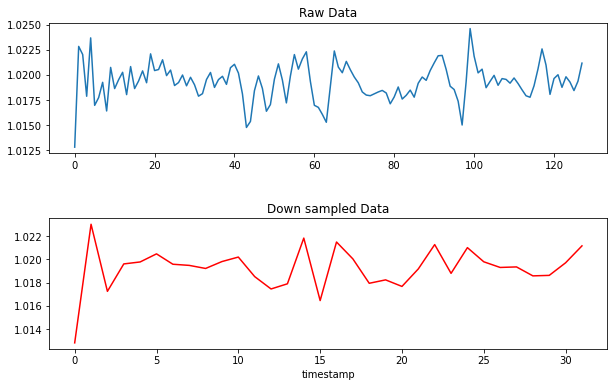

In [35]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
fig.subplots_adjust(hspace=0.5)

#Plot the raw data ts
ax1.plot(X_train[0])
ax1.set_title('Raw Data')

#Plot the down sampled ts
ax2.plot(X_train_down_sampled[0], c='r')
ax2.set_title('Down sampled Data')
ax2.set_xlabel('timestamp')

plt.show()

In [36]:
### Reducing the size of the dataset
sampling_strategy_ = {1: 100,2: 100,3: 100,4: 100,5: 100,6: 100}
rus = RandomUnderSampler(random_state=42, sampling_strategy= sampling_strategy_)
X_res, y_res = rus.fit_resample(X_train_down_sampled, y_train)

In [37]:
print('y_res %s' % Counter(y_res))

y_res Counter({1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100})


### 5-NN with Euclidean Distance

In [38]:
from pyts.classification import KNeighborsClassifier

In [39]:
clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf.fit(X_res, y_res)

KNeighborsClassifier(n_neighbors=5, weights='distance')

In [40]:
%%time
y_pred = clf.predict(X_test_down_sampled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.54      0.78      0.64       496
           2       0.63      0.51      0.56       471
           3       0.92      0.35      0.50       420
           4       0.47      0.42      0.44       491
           5       0.50      0.67      0.57       532
           6       1.00      1.00      1.00       537

    accuracy                           0.63      2947
   macro avg       0.68      0.62      0.62      2947
weighted avg       0.67      0.63      0.63      2947

CPU times: user 98.4 ms, sys: 30.1 ms, total: 129 ms
Wall time: 98 ms


### 5-NN with DTW (baseline)

In [41]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

In [42]:
clf = KNeighborsTimeSeriesClassifier(n_neighbors=5, weights='distance') # default distance = 'dtw'
clf.fit(X_res, y_res)

KNeighborsTimeSeriesClassifier(n_neighbors=5, weights='distance')

In [43]:
%%time
y_pred = clf.predict(X_test_down_sampled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.95      0.79       496
           2       0.69      0.62      0.66       471
           3       0.93      0.58      0.71       420
           4       0.57      0.48      0.52       491
           5       0.58      0.66      0.62       532
           6       1.00      1.00      1.00       537

    accuracy                           0.72      2947
   macro avg       0.74      0.72      0.72      2947
weighted avg       0.74      0.72      0.72      2947

CPU times: user 16.6 s, sys: 115 ms, total: 16.7 s
Wall time: 16.8 s


### ROCKET

In [13]:
from pyts.transformation import ROCKET
from sklearn.linear_model import RidgeClassifierCV

In [14]:
%%time
rocket = ROCKET(random_state=42)
rocket.fit(X_res)
X_train_transform = rocket.transform(X_res)
clf = RidgeClassifierCV().fit(X_train_transform, y_res)

CPU times: user 13.5 s, sys: 526 ms, total: 14.1 s
Wall time: 13.7 s


In [15]:
X_test_transform = rocket.transform(X_test_down_sampled)
y_pred = clf.predict(X_test_transform)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.86      0.94      0.90       496
           2       0.86      0.82      0.84       471
           3       0.92      0.85      0.88       420
           4       0.62      0.38      0.48       491
           5       0.58      0.79      0.67       532
           6       1.00      1.00      1.00       537

    accuracy                           0.80      2947
   macro avg       0.81      0.80      0.79      2947
weighted avg       0.80      0.80      0.79      2947



### Canonical Interval Forest (CIF)

In [16]:
from sktime.classification.interval_based import CanonicalIntervalForest

In [17]:
%%time
clf = CanonicalIntervalForest(n_estimators=30)
clf.fit(X_res, y_res)

CPU times: user 1min 53s, sys: 13.4 s, total: 2min 7s
Wall time: 2min 16s


CanonicalIntervalForest(n_estimators=30)

In [18]:
y_pred = clf.predict(X_test_down_sampled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.74      0.94      0.83       496
           2       0.81      0.74      0.77       471
           3       0.90      0.71      0.79       420
           4       0.57      0.45      0.51       491
           5       0.58      0.69      0.63       532
           6       1.00      1.00      1.00       537

    accuracy                           0.76      2947
   macro avg       0.77      0.75      0.75      2947
weighted avg       0.76      0.76      0.76      2947

